In [1]:
!pip install pandas numpy tensorflow opencv-python matplotlib

  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl (39.0 MB)


In [1]:
!pip install scikit-learn



  Using cached scikit_learn-1.7.2-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.7.2-cp313-cp313-win_amd64.whl (8.7 MB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/38.5 MB ? eta -:--:--
    --------------------------------------- 0.8/38.5 MB 2.4 MB/s eta 0:00:16
   - -------------------------------------- 1.0/38.5 MB 2.2 MB/s eta 0:00:18
   - -------------------------------------- 1.6/38.5 MB 2.0 MB/s eta 0:00:19
   - -------------------------------------- 1.8/38.5 MB 2.1 MB/s eta 0:00:18
   -- ------------------------------------- 2.4/38.5 MB 2.0 MB/s eta 0:00:18
   -- ------------------------------------- 2.9/38.5 MB 2.1 MB/s eta 0:00:17
   --- ------------------------------------ 3.7/38.5 MB 2.3 MB/s eta 0

Loading data...
------------------------------
Total Samples in CSV: 34794
Corrupted Samples Skipped: 1
Clean Samples Loaded: 34793
Training Samples: 27834
Testing Samples: 6959
Data Preparation Complete.
------------------------------


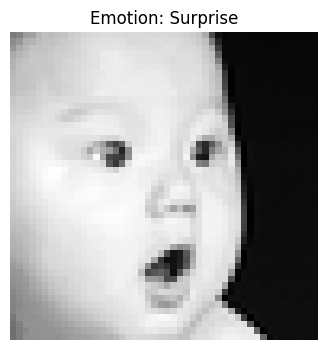

In [6]:
# Cell 2: Data Preparation (CORRECTED)
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# --- CONFIGURATION ---
IMG_SIZE = 48
NUM_CLASSES = 7
EMOTION_LABELS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'] 
MODEL_NAME = 'emotion_model.h5'
EXPECTED_PIXELS = IMG_SIZE * IMG_SIZE # 48 * 48 = 2304

# --- 1. Load the Dataset ---
print("Loading data...")
try:
    df = pd.read_csv(r"C:\Users\Ajay\Downloads\archive\fer2013.csv")
except FileNotFoundError:
    print("Error: fer2013.csv not found. Please ensure it's uploaded to your notebook environment.")
    exit()

# --- 2. Extract Pixels and Labels (with Error Handling) ---
X = [] 
y = [] 
corrupted_rows = 0

for index, row in df.iterrows():
    pixels = np.array(row['pixels'].split(), 'float32')
    
    # *** CORRECTION: Check pixel count before reshaping ***
    if len(pixels) == EXPECTED_PIXELS:
        # Reshape to (48, 48, 1) for grayscale CNN input
        image = pixels.reshape(IMG_SIZE, IMG_SIZE, 1)
        X.append(image)
        y.append(row['emotion'])
    else:
        # Skip this row if the pixel count is wrong
        corrupted_rows += 1
        # print(f"Skipping row {index}: expected 2304 pixels, found {len(pixels)}") # Uncomment for detail

# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

# --- 3. Normalization and One-Hot Encoding ---
X = X / 255.0
y = to_categorical(y, num_classes=NUM_CLASSES)

# --- 4. Split the Data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("-" * 30)
print(f"Total Samples in CSV: {len(df)}")
print(f"Corrupted Samples Skipped: {corrupted_rows}")
print(f"Clean Samples Loaded: {len(X)}")
print(f"Training Samples: {len(X_train)}")
print(f"Testing Samples: {len(X_test)}")
print("Data Preparation Complete.")
print("-" * 30)

# --- Visualize a sample image ---
plt.figure(figsize=(4, 4))
plt.imshow(X_train[0].squeeze(), cmap='gray')
plt.title(f"Emotion: {EMOTION_LABELS[np.argmax(y_train[0])]}")
plt.axis('off')
plt.show()

In [7]:
# Cell 3: CNN Model Training
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- 1. Define the CNN Architecture ---
def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    
    # Block 1
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Block 2
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Block 3
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

model = create_cnn_model((IMG_SIZE, IMG_SIZE, 1), NUM_CLASSES)
# Output Example: model.summary() table
model.summary() 

# --- 2. Compile and Define Callbacks ---
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=10, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=5, 
    min_lr=0.00001
)

# --- 3. Train the Model ---
EPOCHS = 50 
BATCH_SIZE = 64

print("\nStarting Model Training...")
# Output Example: Epoch logs showing loss and accuracy
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)

# --- 4. Save the Trained Model ---
model.save(MODEL_NAME)
print(f"\nModel saved as {MODEL_NAME}")

C:\Users\Ajay\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,653,671 (10.12 MB)

 Trainable params: 2,651,751 (10.12 MB)

 Non-trainable params: 1,920 (7.50 KB)


Starting Model Training...
Epoch 1/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 419s 909ms/step - accuracy: 0.3417 - loss: 1.9115 - val_accuracy: 0.3508 - val_loss: 1.6845 - learning_rate: 0.0010
Epoch 2/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 434s 891ms/step - accuracy: 0.4626 - loss: 1.4251 - val_accuracy: 0.5042 - val_loss: 1.3116 - learning_rate: 0.0010
Epoch 3/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 384s 882ms/step - accuracy: 0.5213 - loss: 1.2630 - val_accuracy: 0.5254 - val_loss: 1.2324 - learning_rate: 0.0010
Epoch 4/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 383s 880ms/step - accuracy: 0.5502 - loss: 1.1902 - val_accuracy: 0.5647 - val_loss: 1.1493 - learning_rate: 0.0010
Epoch 5/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 389s 894ms/step - accuracy: 0.5734 - loss: 1.1290 - val_accuracy: 0.5258 - val_loss: 1.2464 - learning_rate: 0.0010
Epoch 6/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 388s 891ms/step - accuracy: 0.5918 - loss: 1.0822 - val_accuracy: 0.5463 - val_loss: 1.2097 - learning_rate: 0.0010
Epoch 7/50
435/435 ━━━━━━━━━━━━━━━━━


Model saved as emotion_model.h5


In [ ]:
# Cell 4: Live Webcam Detection (CORRECTED)
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import sys # Import sys for controlled exit

# --- CONFIGURATION ---
MODEL_NAME = 'emotion_model.h5'
IMG_SIZE = 48 
EMOTION_LABELS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# --- 1. Load Resources ---
print("\nLoading Model and Face Classifier...")
try:
    # Load the trained emotion classification model
    classifier = load_model(MODEL_NAME) 
    
    # Load the Haar Cascade classifier for face detection
    # FIX: Corrected typo from 'haascades' to 'haarcascades'
    face_classifier = cv2.CascadeClassifier(
        cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
    )
    is_loaded = True
    
except Exception as e:
    # If loading fails, print error and set a flag to prevent the loop from starting
    print(f"ERROR loading resources: {e}")
    print("ACTION REQUIRED: Ensure 'emotion_model.h5' exists and the path is correct.")
    is_loaded = False


# --- 2. Video Capture and Initialization Check ---
if not is_loaded:
    # Prevent the rest of the code from running if resources failed to load
    print("Real-time detection aborted due to loading errors.")
else:
    cap = cv2.VideoCapture(0) # 0 for default webcam
    
    if not cap.isOpened():
        print("ERROR: Could not open webcam (Check if another program is using it).")
        # sys.exit(1) # Use sys.exit(1) if running as a script, but break in Notebook
        cap.release()
    else:
        print("\nStarting Real-Time Emotion Detection. Press 'q' to quit in the OpenCV window.")

        # --- 3. Real-Time Loop ---
        while True:
            ret, frame = cap.read()
            if not ret:
                break
        
            # Convert frame to grayscale and detect faces
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            # Detect faces
            faces = face_classifier.detectMultiScale( # 'face_classifier' is now defined!
                gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30)
            )
        
            for (x, y, w, h) in faces:
                # Draw bounding box
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 255), 2)
                
                # Extract and preprocess the Face ROI (Region of Interest)
                roi_gray = gray[y:y + h, x:x + w]
                roi_gray = cv2.resize(roi_gray, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
        
                if np.sum([roi_gray]) != 0:
                    # Prepare image for model prediction
                    roi = roi_gray.astype('float32') / 255.0
                    roi = np.expand_dims(roi, axis=-1)  
                    roi = np.expand_dims(roi, axis=0)  
        
                    # Predict Emotion
                    prediction = classifier.predict(roi, verbose=0)[0]
                    emotion_index = prediction.argmax()
                    label = EMOTION_LABELS[emotion_index]
                    confidence = prediction[emotion_index]
        
                    # Display Result
                    label_text = f"{label} ({confidence*100:.1f}%)"
                    cv2.putText(
                        frame, label_text, (x, y - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2
                    )
                else:
                    cv2.putText(frame, 'No Face', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
        
            # Show the output frame
            cv2.imshow('Emotion Detector', frame)
        
            # Exit on 'q' press
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        
        # --- 4. Cleanup ---
        cap.release()
        cv2.destroyAllWindows()
        print("Application closed.")


Loading Model and Face Classifier...



Starting Real-Time Emotion Detection. Press 'q' to quit in the OpenCV window.
